In [1]:
import sys
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)

Mounted at /content/gdrive


In [2]:
data_path = '/content/gdrive/MyDrive/Deep_Learning_UTEN/TFKB_NUFFT_MV_DWI_CNN'
sys.path.insert(0,data_path)

In [3]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import time, pdb, os
import scipy.io as sio
import glob

from skimage.data import shepp_logan_phantom
from tfkbnufft import kbnufft_forward, kbnufft_adjoint
from tfkbnufft.kbnufft import KbNufftModule
from tfkbnufft.mri.dcomp_calc import calculate_radial_dcomp_tf, calculate_density_compensator
dtype = tf.float32

In [4]:
class DataGenerator(tf.keras.utils.Sequence):

    def __init__(self, filename_list,num_rows, num_cols, num_coils, num_blades,batch_size,
                 shuffle=True):

        self.filename_list = filename_list
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.num_samples = len(self.filename_list)
        self.num_rows = num_rows
        self.num_cols = num_cols
        self.num_coils = num_coils
        self.num_blades = num_blades
        self.on_epoch_end()

    def on_epoch_end(self):
        if self.shuffle:
            #Shuffle the filename list in-place
            np.random.shuffle(self.filename_list)

    def __get_data(self, filenames):

        csm = np.empty((self.batch_size,self.num_coils,self.num_rows,self.num_cols)).astype(np.csingle)
        kmask = np.empty((self.batch_size,self.num_coils, self.num_rows*self.num_cols,self.num_blades)).astype(np.csingle)
        kdata = np.empty((self.batch_size,self.num_coils, self.num_rows*self.num_cols,self.num_blades)).astype(np.csingle)      
        label_img = np.empty((self.batch_size,self.num_rows,self.num_cols,self.num_blades*2))
        b0_img = np.empty((self.batch_size,self.num_rows,self.num_cols,self.num_blades)).astype(np.csingle)
        K_coord = np.empty((self.batch_size,2,self.num_rows*self.num_cols,self.num_blades))

        for idx, curr_filename in enumerate(filenames):
            kdata[idx,], K_coord[idx,], csm[idx,], kmask[idx,], b0_img[idx,], label_img[idx,] = self.prepare_single_input_output_pair(curr_filename)
        return tuple([kdata,K_coord,csm,kmask,b0_img]), label_img

    # Return the index'th batch
    def __getitem__(self, index):
        curr_filenames = self.filename_list[index * self.batch_size:(index + 1) * self.batch_size]
        X, y = self.__get_data(curr_filenames)

        return X, y

    def __len__(self):
        return self.num_samples // self.batch_size

    def prepare_single_input_output_pair(self,filename_one_sample):
        temp = sio.loadmat(filename_one_sample)
        label_img = temp['label_img'].astype(np.csingle)
        #label_img = label_img/np.max(np.abs(label_img))
        b0_img = temp['b0'].astype(np.csingle)
        #b0_img = 0.4*b0_img/np.max(np.abs(b0_img))
        K_coord = temp['K_coord']

        kdata = temp['kdata'].astype(np.csingle)
        #kdata = 5*kdata/np.max(np.abs(kdata))
        kmask = temp['kmask'].astype(np.csingle)
        csm = temp['csm'].astype(np.csingle)

        Nc = 12
        N = 128
        Np = 7
        kdata = np.transpose(kdata,[2,0,1,3])
        kmask = np.transpose(kmask,[2,0,1,3])
        kdata = np.reshape(kdata,[Nc,N*N,Np])
        kmask = np.reshape(kmask,[Nc,N*N,Np])
          
        return kdata, K_coord, csm, kmask, b0_img, complex_to_real(label_img)


In [5]:
num_blades = 7;
num_rows = 128
num_cols = 128
num_coils = 12
num_batchs = 4

# ####################################################
# Angle = np.linspace(0, 180-1, 180)*np.pi/180
# Angle = Angle[0::int(180/num_blades)]

N=num_rows
im_size = [N,N]
grid_size = [2*N, 2*N]
nufft_ob = KbNufftModule(im_size=im_size, grid_size=grid_size, norm='ortho')
nufft_ob.numpoints = (5,5)
nufft_ob.numpoints_tensor = (5,5)

import tensorflow as tf
from tensorflow.keras.layers import Input, Add, Subtract, Lambda, LayerNormalization
from tensorflow.keras.models import Model

########
fft2c = Lambda(lambda x: fft2c_tf(x))
ifft2c = Lambda(lambda x: ifft2c_tf(x))
fft2c_coil = Lambda(lambda x: fft2c_coil_tf(x))
ifft2c_coil = Lambda(lambda x: ifft2c_coil_tf(x))

complex_to_real = Lambda(lambda x: complex_to_real_tf(x))
real_to_complex = Lambda(lambda x: real_to_complex_tf(x))

virtual_coil = Lambda(lambda x: virtual_coil_tf(x))
actual_coil = Lambda(lambda x: actual_coil_tf(x))

#######################################################################################
def virtual_coil_tf(image):
    vc_image = tf.transpose(image,(0,2,1,3),conjugate=True)
    image_out = tf.concat((image,vc_image),axis=3) 
    return image_out

def actual_coil_tf(image):
    tmp1 = 0.5*(image[...,0]+tf.transpose(image[...,2],(0,2,1),conjugate=True))
    tmp2 = 0.5*(image[...,1]+tf.transpose(image[...,3],(0,2,1),conjugate=True))
    image_out = tf.stack([tmp1,tmp2],axis = -1) 
    return image_out

def complex_to_real_tf(image):
    image_out = tf.stack([tf.math.real(image), tf.math.imag(image)], axis=-1)
    shape_out = tf.concat([tf.shape(image)[:-1], [image.shape[-1]*2]],axis=0)
    image_out = tf.reshape(image_out, shape_out)
    return image_out

def real_to_complex_tf(image):
    image_out = tf.reshape(image, [-1, 2])
    image_out = tf.complex(image_out[:, 0], image_out[:, 1])
    shape_out = tf.concat([tf.shape(image)[:-1], [image.shape[-1] // 2]],axis=0)
    image_out = tf.reshape(image_out, shape_out)
    return image_out


def fft2c_tf(x):
    # x: [batch, row, col] ... x in this case
    # tf.signal.fft2d computes the 2-dimensional discrete Fourier transform over the inner-most 2 dimensions of input.
    # Inner-most dimension = right-most dimension

    Fx = tf.signal.fftshift(tf.signal.fft2d(tf.signal.fftshift(x, axes=(-2, -1))), axes=(-2, -1))/tf.cast(tf.math.sqrt(float(x.shape[-2]*x.shape[-1])),dtype=tf.complex64)
    return Fx

def ifft2c_tf(x):
    # x: [batch, row, col] ...k in this case
    # tf.signal.ifft2d computes the 2-dimensional discrete Fourier transform over the inner-most 2 dimensions of input.
    Ft_x = tf.signal.ifftshift(tf.signal.ifft2d(tf.signal.ifftshift(x, axes=(-2, -1))), axes=(-2, -1))*tf.cast(tf.math.sqrt(float(x.shape[-2]*x.shape[-1])),dtype=tf.complex64)
    return Ft_x

# fft2c with coil dimension
def fft2c_coil_tf(x):
    # x: [batch, row, col, coil] ... Cx in this case
    # tf.signal.fft2d computes the 2-dimensional discrete Fourier transform over the inner-most 2 dimensions of input.
    # Inner-most dimension = right-most dimension
    # So, we need to swap things around
    x = tf.transpose(x, perm=(0, 3, 1, 2))  # -> [batch, coil, row, col]

    Fx = tf.signal.fftshift(tf.signal.fft2d(tf.signal.fftshift(x, axes=(-2, -1))), axes=(-2, -1))/tf.cast(tf.math.sqrt(float(x.shape[-2]*x.shape[-1])),dtype=tf.complex64)
    return tf.transpose(Fx, perm=(0, 2, 3, 1))  # -> Back to [batch, row, col, coil]

# ifft2c with coil dimension
def ifft2c_coil_tf(x):
    # x: [batch, row, col, coil] ...Mt_k in this case
    # tf.signal.ifft2d computes the 2-dimensional discrete Fourier transform over the inner-most 2 dimensions of input.
    x = tf.transpose(x, perm=(0, 3, 1, 2))  # -> [row,col,coil, batch]
    Ft_x = tf.signal.ifftshift(tf.signal.ifft2d(tf.signal.ifftshift(x, axes=(-2, -1))), axes=(-2, -1))*tf.cast(tf.math.sqrt(float(x.shape[-2]*x.shape[-1])),dtype=tf.complex64)
    return tf.transpose(Ft_x, perm=(0, 2, 3, 1))  # -> Back to [batch, row, col, coil]

def AH_propeller(kdata,K_coord,csm,kmask,Np):
  X = []
  for it in range(Np):
      # nufft_ob = Nufft_P[it]
      ktraj = K_coord[:,:,:,it]
      kdata0 = kdata[:,:,:,it]
      kmask0 = kmask[:,:,:,it]
      out = compute_Ah()(kdata0,ktraj,csm,kmask0)
      X.append(out)

  return tf.stack(X,axis=-1)

def AHA_propeller(img,K_coord,csm,kmask,Np):
  X = []
  for it in range(Np):
      # nufft_ob = Nufft_P[it]
      ktraj = K_coord[:,:,:,it]
      img0 = img[:,:,:,it]
      kmask0 = kmask[:,:,:,it]
      out = getDataTerm_AhAx()(img0,ktraj,csm,kmask0)
      X.append(out)

  return tf.stack(X,axis=-1)

def transpos_nufft(kdata,ktraj,csm,kmask):
    img = kbnufft_adjoint(nufft_ob._extract_nufft_interpob())(tf.multiply(kdata,kmask), ktraj)
    img_sumC = img*tf.math.conj(csm)
    out = tf.reduce_sum(img_sumC,axis=1)

    return out

def forward_nufft(img,ktraj,csm,kmask):
    img = tf.expand_dims(img, axis=1)
    # csm = tf.expand_dims(csm, axis=-1)
    imgC = tf.multiply(img, csm)
    out = kbnufft_forward(nufft_ob._extract_nufft_interpob())(imgC, ktraj)

    return out*kmask

class compute_Ah(tf.keras.layers.Layer):

    # __init__ , where you can do all input-independent initialization
    def __init__(self):
        super(compute_Ah, self).__init__()
        self.transpos_nufft = transpos_nufft

    # # build, where you know the shapes of the input tensors and can do the rest of the initialization
    def build(self, input_shape):
        super(compute_Ah, self).build(input_shape)

    # call, where you do the forward computation
    def call(self,x,ktraj,csm,kmask):
        # inputs: x, C, M, W

        # Compute Ah(A(x))
        return self.transpos_nufft(x,ktraj,csm,kmask)

class getDataTerm_AhAx(tf.keras.layers.Layer):

    # __init__ , where you can do all input-independent initialization
    def __init__(self):
        super(getDataTerm_AhAx, self).__init__()

    # # build, where you know the shapes of the input tensors and can do the rest of the initialization
    def build(self, input_shape):
        super(getDataTerm_AhAx, self).build(input_shape)

    # call, where you do the forward computation
    def call(self,x,ktraj,csm,kmask):
        # inputs: x, C, M, W

        # Compute Ah(A(x))
        return transpos_nufft(forward_nufft(x,ktraj,csm,kmask),ktraj,csm,kmask)

from tensorflow.keras.layers import Input, Add, Subtract, Lambda, LayerNormalization
from tensorflow.keras.models import Model
from utils.compute_nrmse import compute_nrmse
# from models.tensorflow_utils import fft2c, ifft2c
# from models.tensorflow_utils import complex2real, real2complex
# from models.buda_utils import ifft2c, fft2c

def KINet_large(data_consistency_type,
         num_rows,
         num_cols,
         num_coils,
         num_blades,
         num_GD_blocks=6,
         num_inner_GD_iters=1,
         GD_step_size=0.9,
         activation_type='prelu',
         use_DL_regularizer=True,
         pretrained_reg_net_path=None,
         pretrained_inet_path=None,
         data_consistency_before_reg=True,
         use_layer_norm=False):

    if pretrained_inet_path is not None:
        pretrained_weights_reg_path = None

    #### Create a model
    # undersampled_ispace_buda = Input(shape=(num_rows-8, num_cols-8), dtype=tf.complex64)  # undersampled (image space)
    csm = Input(shape=(num_coils, num_rows, num_cols), dtype=tf.complex64)
    kmask = Input(shape=(num_coils,num_rows*num_cols, num_blades), dtype=tf.complex64)
    kdata = Input(shape=(num_coils,num_rows*num_cols, num_blades), dtype=tf.complex64)
    K_coord = Input(shape=(2,num_rows*num_cols, num_blades), dtype = tf.float32)
    b0_img = Input(shape=(num_rows, num_cols, num_blades), dtype=tf.complex64)

    if use_DL_regularizer:

        from models.UNet2D_ import UNet2D

        reg_models = {}
        for idx_block in range(num_GD_blocks):
            reg_models[str(idx_block)] = UNet2D(im_size=num_rows, kernel_size=3, num_out_chan_highest_level=128,
                           depth=5, num_chan_increase_rate=2, activation_type=activation_type,
                           dropout_rate=0.0001, SEPARABLE_CONV=False, SKIP_CONNECTION_AT_THE_END=True,
                           num_input_chans=14*2, num_output_chans=14)

            # if pretrained_reg_net_path is not None:
            #     reg_models[str(idx_block)].load_weights(pretrained_reg_net_path)

    ########################################################################################################################
    b0_k = fft2c_coil(b0_img)
    b0_i = complex_to_real(b0_img)
    b0_k = complex_to_real(b0_k)
    ########################################################################################################################


    #num_batchs = wmap_buda.shape[0]
    x = AH_propeller(kdata,K_coord,csm,kmask,num_blades)
    Ahb = x
    # Ahb = compute_Ah()(kdata_buda, csm_buda, mask_buda, wmap_buda)
    # We define it here (not in the for-loop below) to avoid creating new function every GD iteration

    for idx_block in range(round(num_GD_blocks/2)):

        if data_consistency_before_reg:

            for idx_inner_iter in range(num_inner_GD_iters):
                AhAx = AHA_propeller(x,K_coord,csm,kmask,num_blades)

                # Compute the gradient of the data consistency term: Ah(A(x)) - Ah(b)
                # GD_grad = AhAx - Ahb  # grad_x 1/2||Ax-b||^2 = Ah(A(x)) - Ah(b)
                GD_grad = Subtract()([AhAx, Ahb])

                # Update the solution: shape = batch x 200 x 200
                # x = x - GD_step_size * GD_grad  # [None, row,col,coil] complex64

                temp = Lambda(lambda x: x * GD_step_size)(GD_grad)
                x = Subtract()([x, temp])

            # Include UNet as a regularizer in k-space
            if use_DL_regularizer:

                # image- to k-space
                x = fft2c_coil(x)

                # complex to real: output shape = batch x row x col x 2 (real/imag)
                x = complex_to_real(x)

                # Pass the images to the regularization network
                if use_layer_norm:
                    x = LayerNormalization(axis=[1,2,3])(x)
                x = reg_models[str(2*idx_block)](tf.concat(axis=3, values=[x, b0_k]))

                # Real to complex
                x = real_to_complex(x)

                # k- to image-space
                x = ifft2c_coil(x)

            for idx_inner_iter in range(num_inner_GD_iters):
                AhAx = AHA_propeller(x,K_coord,csm,kmask,num_blades)

                # Compute the gradient of the data consistency term: Ah(A(x)) - Ah(b)
                # GD_grad = AhAx - Ahb  # grad_x 1/2||Ax-b||^2 = Ah(A(x)) - Ah(b)
                GD_grad = Subtract()([AhAx, Ahb])

                # Update the solution: shape = batch x 200 x 200
                # x = x - GD_step_size * GD_grad  # [None, row,col,coil] complex64

                temp = Lambda(lambda x: x * GD_step_size)(GD_grad)
                x = Subtract()([x, temp])

            # Include UNet as a regularizer in image-space
            if use_DL_regularizer:

                # complex to real: output shape = batch x row x col x 2 (real/imag)
                x = complex_to_real(x)

                # Pass the images to the regularization network
                if use_layer_norm:
                    x = LayerNormalization(axis=[1,2,3])(x)
                x = reg_models[str(2*idx_block+1)](tf.concat(axis=3, values=[x, b0_i]))

                # Real to complex
                x = real_to_complex(x)

        else:

            # Include UNet as a regularizer in k-space
            if use_DL_regularizer:

                # image- to k-space
                x = fft2c_coil(x)

                # complex to real: output shape = batch x row x col x 2 (real/imag)
                x = complex_to_real(x)

                # Pass the images to the regularization network
                if use_layer_norm:
                    x = LayerNormalization(axis=[1,2,3])(x)
                x = reg_models[str(2*idx_block)](tf.concat(axis=3, values=[x, b0_k]))

                # Real to complex
                x = real_to_complex(x)

                # k- to image-space
                x = ifft2c_coil(x)

            for idx_inner_iter in range(num_inner_GD_iters):
                AhAx = AHA_propeller(x,K_coord,csm,kmask,num_blades)

                # Compute the gradient of the data consistency term: Ah(A(x)) - Ah(b)
                # GD_grad = AhAx - Ahb  # grad_x 1/2||Ax-b||^2 = Ah(A(x)) - Ah(b)
                GD_grad = Subtract()([AhAx, Ahb])


                # Update the solution: shape = batch x 200 x 200
                # x = x - GD_step_size * GD_grad  # [None, row,col,coil] complex64

                temp = Lambda(lambda x: x * GD_step_size)(GD_grad)
                x = Subtract()([x, temp])

            # Include UNet as a regularizer in image-space
            if use_DL_regularizer:

                # complex to real: output shape = batch x row x col x 2 (real/imag)
                x = complex_to_real(x)

                # Pass the images to the regularization network
                if use_layer_norm:
                    x = LayerNormalization(axis=[1,2,3])(x)
                x = reg_models[str(2*idx_block+1)](tf.concat(axis=3, values=[x, b0_i]))

                # Real to complex
                x = real_to_complex(x)


            for idx_inner_iter in range(num_inner_GD_iters):
                AhAx = AHA_propeller(x,K_coord,csm,kmask,num_blades)

                # Compute the gradient of the data consistency term: Ah(A(x)) - Ah(b)
                # GD_grad = AhAx - Ahb  # grad_x 1/2||Ax-b||^2 = Ah(A(x)) - Ah(b)
                GD_grad = Subtract()([AhAx, Ahb])


                # Update the solution: shape = batch x 200 x 200
                # x = x - GD_step_size * GD_grad  # [None, row,col,coil] complex64

                temp = Lambda(lambda x: x * GD_step_size)(GD_grad)
                x = Subtract()([x, temp])

    output_data = complex_to_real(x)

    # model = Model(inputs=[undersampled_ispace_buda, csm_buda, mask_buda, wmap_buda, kdata_buda], outputs=output_data)
    model = Model(inputs=[kdata,K_coord,csm,kmask, b0_img], outputs=output_data)

    if pretrained_inet_path is not None:
        model.load_weights(pretrained_inet_path)

    return model

In [6]:
    #input_paths = glob.glob(os.path.join(data_path, "Train_with_B0_ALL/*.mat"))#"T_with_b0/*.mat"))#"Train_with_B0_ALL/*.mat"))#"T_with_b0/*.mat"))# "TTT/*.mat"))# 
    input_paths = glob.glob(os.path.join(data_path, "Case_8_TT/*.mat"))
    #input_paths = glob.glob(os.path.join(data_path, "Test_BB/*.mat"))

    decode = tf.image.decode_png

    if len(input_paths) == 0:
        raise Exception("input_dir contains no image files")

    def get_name(path):
        name, _ = os.path.splitext(os.path.basename(path))
        return name

    # if the image names are numbers, sort by the value rather than asciibetically
    # having sorted inputs means that the outputs are sorted in test mode
    if all(get_name(path).isdigit() for path in input_paths):
        input_paths = sorted(input_paths, key=lambda path: int(get_name(path)))
    else:
        input_paths = sorted(input_paths)

    training_gen = DataGenerator(input_paths,num_rows, num_cols, num_coils, num_blades,num_batchs,shuffle=True)
#######################################################################################################################
    #input_paths = glob.glob(os.path.join(data_path, "Validate_with_B0_ALL/*.mat"))#"V_with_b0/*.mat"))#"Validate_with_B0_ALL/*.mat"))#"V_with_b0/*.mat"))# "VVV/*.mat"))#
    input_paths = glob.glob(os.path.join(data_path, "Case_8_VV/*.mat"))
    decode = tf.image.decode_png

    if len(input_paths) == 0:
        raise Exception("input_dir contains no image files")

    def get_name(path):
        name, _ = os.path.splitext(os.path.basename(path))
        return name

    # if the image names are numbers, sort by the value rather than asciibetically
    # having sorted inputs means that the outputs are sorted in test mode
    if all(get_name(path).isdigit() for path in input_paths):
        input_paths = sorted(input_paths, key=lambda path: int(get_name(path)))
    else:
        input_paths = sorted(input_paths)

    val_gen = DataGenerator(input_paths,num_rows, num_cols, num_coils, num_blades,num_batchs,shuffle=True)

In [7]:
# "Important" parameters
import os
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

model_type = 'ki-net' # Options: 'unet', 'inet'
data_consistency_type = 'propeller'

num_GD_blocks = 2
num_inner_GD_iters = 1
GD_step_size = 0.9 # Step size for the data-consistency-gradient update
data_consistency_before_reg = True # For 'inet', 'knet', 'kikinet'
use_DL_regularize = True
# Deep learning parameters
num_epochs = 700
loss = 'nrmse'
activation_type = 'relu'
learning_rate_base = 2e-4
batch_size = num_batchs


tensorboard_filepath = os.path.join(data_path,'results')
model_checkpoint_filepath = os.path.join(data_path,'trained_weights', 'kinet_weights_prelu_DWI_with_B0_BB.h5')#_ALL.h5')
#model_checkpoint_filepath = os.path.join(data_path,'trained_weights', 'kinet_weights_prelu_DWI_with_B0_2B.h5')#_ALL.h5')
pre_train_path = ''
pretrained_reg_net_path = ''
pretrained_unrolled_net_path = ''
#pretrained_unrolled_net_path = os.path.join(data_path,'trained_weights', 'kinet_weights_prelu_DWI_with_B0_2B.h5')#_ALL.h5')
pretrained_unrolled_net_path = os.path.join(data_path,'trained_weights', 'kinet_weights_prelu_DWI_with_B0_BB.h5')

if not os.path.exists(pretrained_reg_net_path):
    pretrained_reg_net_path = None

if not os.path.exists(pretrained_unrolled_net_path):
    pretrained_unrolled_net_path = None

In [8]:
if model_type == 'ki-net':
    model = KINet_large(data_consistency_type,
                 num_rows,
                 num_cols,
                 num_coils,
                 num_blades,
                 num_GD_blocks,
                 num_inner_GD_iters,
                 GD_step_size,
                 activation_type,
                 pretrained_reg_net_path=pretrained_reg_net_path,
                 pretrained_inet_path=pretrained_unrolled_net_path,
                 data_consistency_before_reg=data_consistency_before_reg,
                 use_layer_norm = False)

    
# elif model_type == 'unet':
#     model = UNet2D(im_size=num_rows, kernel_size=3, num_out_chan_highest_level=64, 
#                    depth=3, num_chan_increase_rate=2, activation_type=activation_type, 
#                    dropout_rate=0.05,SEPARABLE_CONV=False, SKIP_CONNECTION_AT_THE_END=True, 
#                    num_input_chans=4, num_output_chans=4)
    
#     if pretrained_reg_net_path is not None:
#         model.load_weights(pretrained_reg_net_path)

Instructions for updating:
Use fn_output_signature instead


In [9]:
# Compile the model
import tensorflow.keras.backend as K

adam_opt = Adam(learning_rate=learning_rate_base, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=1e-4)
tbCallBack = TensorBoard(log_dir=tensorboard_filepath, histogram_freq=0, write_graph=False, write_images=False)
checkpointerCallBack = ModelCheckpoint(filepath=model_checkpoint_filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

if loss == 'nrmse':
    # Objective function
    def my_objective_function(y_true, y_pred):
        return 100 * K.sqrt(K.sum(K.square(y_pred - y_true))) / K.sqrt(K.sum(K.square(y_true)))

    model.compile(loss=my_objective_function, optimizer=adam_opt)
else:
    model.compile(loss=loss, optimizer=adam_opt)

In [ ]:
hist = model.fit(x=training_gen, 
                     batch_size=batch_size, 
                     epochs=num_epochs*10, 
                     verbose=2, 
                     callbacks=[tbCallBack,checkpointerCallBack], 
                     validation_data=val_gen, 
                     shuffle=True, 
                     initial_epoch=0)

# hist = model.fit(x=training_gen, 
#                      batch_size=batch_size, 
#                      epochs=10000, 
#                      verbose=2,
#                      shuffle=True, 
#                      initial_epoch=0)


Epoch 268: val_loss did not improve from 10.12834
72/72 - 187s - loss: 11.4662 - val_loss: 10.3502 - 187s/epoch - 3s/step
Epoch 269/7000

Epoch 269: val_loss did not improve from 10.12834
72/72 - 186s - loss: 11.5035 - val_loss: 10.4459 - 186s/epoch - 3s/step
Epoch 270/7000

Epoch 270: val_loss did not improve from 10.12834
72/72 - 186s - loss: 11.6004 - val_loss: 11.0930 - 186s/epoch - 3s/step
Epoch 271/7000

Epoch 271: val_loss improved from 10.12834 to 10.10634, saving model to /content/gdrive/MyDrive/Deep_Learning_UTEN/TFKB_NUFFT_MV_DWI_CNN/trained_weights/kinet_weights_prelu_DWI_with_B0_BB.h5
72/72 - 219s - loss: 11.3202 - val_loss: 10.1063 - 219s/epoch - 3s/step
Epoch 272/7000

Epoch 272: val_loss did not improve from 10.10634
72/72 - 191s - loss: 11.4551 - val_loss: 10.3099 - 191s/epoch - 3s/step
Epoch 273/7000

Epoch 273: val_loss improved from 10.10634 to 10.06935, saving model to /content/gdrive/MyDrive/Deep_Learning_UTEN/TFKB_NUFFT_MV_DWI_CNN/trained_weights/kinet_weights_p

In [ ]:
    #input_paths = glob.glob(os.path.join(data_path, "T_with_b0/*.mat"))
    input_paths = glob.glob(os.path.join(data_path, "Case_8_Test/*.mat"))
    #input_paths = glob.glob(os.path.join(data_path, "Supakarn_Test/*.mat"))
    decode = tf.image.decode_png

    if len(input_paths) == 0:
        raise Exception("input_dir contains no image files")

    def get_name(path):
        name, _ = os.path.splitext(os.path.basename(path))
        return name

    # if the image names are numbers, sort by the value rather than asciibetically
    # having sorted inputs means that the outputs are sorted in test mode
    if all(get_name(path).isdigit() for path in input_paths):
        input_paths = sorted(input_paths, key=lambda path: int(get_name(path)))
    else:
        input_paths = sorted(input_paths)

    test_gen = DataGenerator(input_paths,num_rows, num_cols, num_coils, num_blades,num_batchs,shuffle=False)

In [ ]:
input_paths

In [ ]:
!nvidia-smi

Sat Apr  9 04:01:55 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    35W / 250W |   4469MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
model.summary()

In [ ]:
Total params: 138,530,808
Trainable params: 138,468,120
Non-trainable params: 62,688

In [ ]:
start_time = time.perf_counter()
recon_i = model.predict(test_gen)
end_time = time.perf_counter()
print("done. Time taken: %f seconds." % (end_time - start_time), flush=True)

recon_c = real_to_complex(recon_i)

done. Time taken: 87.603416 seconds.


In [ ]:
34.9/80

0.43624999999999997

In [ ]:
Im=np.mean(np.abs(recon_c),axis=3)

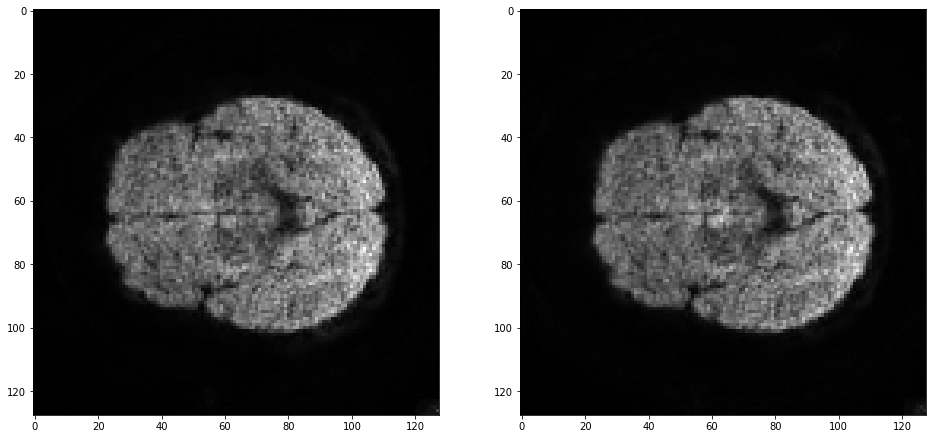

In [ ]:
sl=42

I1 = np.abs(Im[sl,:,:])#+np.abs(Im[sl+1,:,:])
plt.figure(figsize=(16, 16)) 
plt.subplot(1,2,1)
plt.imshow(I1),
plt.gray()

I2 = np.abs(Im[sl+1,:,:])#+np.abs(Im[sl+3,:,:])
plt.subplot(1,2,2)
plt.imshow(I2)
plt.gray()

In [ ]:
data_path = '/content/gdrive/MyDrive/Deep_Learning_UTEN/TFKB_NUFFT_MV_DWI_CNN'
#
sio.savemat(os.path.join(data_path, 'results/cnn_Supakarn.mat'),{'recon_c':np.array(recon_c)})

In [ ]:
data_path = '/content/gdrive/MyDrive/Deep_Learning_UTEN/TFKB_NUFFT_MV_DWI_CNN'
#
sio.savemat(os.path.join(data_path, 'results/cnn_case_8.mat'),{'recon_c':np.array(recon_c)})

In [ ]:
        temp = sio.loadmat(os.path.join(data_path, "Case_8_TT/Case_08_DWI60.mat"))
        label_img = temp['label_img'].astype(np.csingle)
        K_coord = temp['K_coord']
        K_coord = tf.convert_to_tensor(K_coord)[None,...]
        
        kdata = temp['kdata'].astype(np.csingle)
        #kdata = kdata/np.max(np.abs(kdata))
        kmask = temp['kmask'].astype(np.csingle)
        csm = temp['csm'].astype(np.csingle)

        Nc = 12
        N = 128
        Np = 7
        kdata = np.transpose(kdata,[2,0,1,3])
        kmask = np.transpose(kmask,[2,0,1,3])
        kdata = np.reshape(kdata,[Nc,N*N,Np])
        kdata = tf.convert_to_tensor(kdata)[None,...]
        kmask = np.reshape(kmask,[Nc,N*N,Np])
        kmask = tf.convert_to_tensor(kmask)[None,...]
        csm = tf.convert_to_tensor(csm)[None,...]

In [ ]:
np.max(np.abs(x0))

0.69515496

In [ ]:
t = 1
Nit = 15
step_size = 0.9
x0 = AH_propeller(kdata,K_coord,csm,kmask,num_blades)

In [ ]:
Im0=np.mean(np.abs(x0),axis=3)
Im=np.mean(np.abs(x),axis=3)

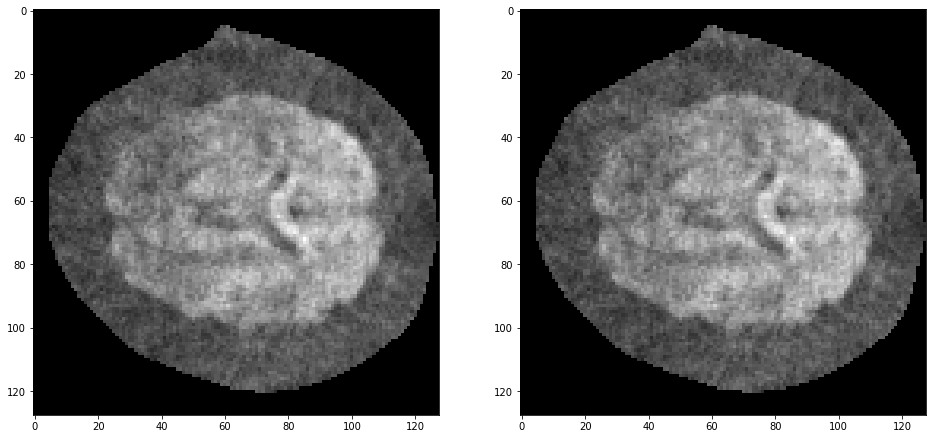

In [ ]:
plt.figure(figsize=(16, 16)) 
plt.subplot(1,2,1)
plt.imshow(np.abs(Im0[0,:,:]))
plt.gray()

plt.subplot(1,2,2)
plt.imshow(np.abs(Im[0,:,:]))
plt.gray()

In [ ]:
def transpos_nufft(kdata,ktraj,csm,kmask):
    img = kbnufft_adjoint(nufft_ob._extract_nufft_interpob())(tf.multiply(kdata,kmask), ktraj)
    img_sumC = img*tf.math.conj(csm)
    out = tf.reduce_sum(img_sumC,axis=1)

    return out

def forward_nufft(img,ktraj,csm,kmask):
    img = tf.expand_dims(img, axis=1)
    # csm = tf.expand_dims(csm, axis=-1)
    imgC = tf.multiply(img, csm)
    out = kbnufft_forward(nufft_ob._extract_nufft_interpob())(imgC, ktraj)

    return out*kmask

In [ ]:
# Using FISTA 
t = 1
Nit = 2
step_size = 0.9
x0 = AH_propeller(kdata,K_coord,csm,kmask,num_blades)
x=x0

for it in range(Nit):
    tmp = AHA_propeller(x,K_coord,csm,kmask,num_blades)
    u = tmp-x0
    x = x - step_size * u

In [ ]:
np.max(DC)

(nan+nanj)

In [ ]:
plt.plot(np.real(tf_dcomp))

In [ ]:
plt.plot(np.real(tf_dcomp))

In [ ]:
sl=14
plt.figure(figsize=(16, 16)) 
plt.subplot(1,2,1)
plt.imshow(np.abs(DC[0,:,:,1]))
plt.gray()

plt.subplot(1,2,2)
plt.imshow(np.abs(DC[0,:,:,6]))
plt.gray()

In [ ]:
tf_ktraj = K_coord*kmask

In [ ]:
  interpob = nufft_ob._extract_nufft_interpob()
  nufftob_back = kbnufft_adjoint(interpob)
  nufftob_forw = kbnufft_forward(interpob)
  Np = 7
  X = []
  for it in range(Np):
      tf_ktraj = K_coord[0,:,:,it]
      tf_dcomp = calculate_density_compensator(interpob, nufftob_forw, nufftob_back, tf_ktraj, zero_grad=True)
      X.append(tf_dcomp)

  dcom = tf.stack(X,axis=-1)

In [ ]:
dcom = tf.stack([dcom] * 12)

In [ ]:
dcom = tf.convert_to_tensor(dcom)[None,...]

In [ ]:
x0 = AH_propeller(kdata*dcom,K_coord,csm,kmask,num_blades)

In [ ]:
x1 = AH_propeller(kdata,K_coord,csm,kmask,num_blades)

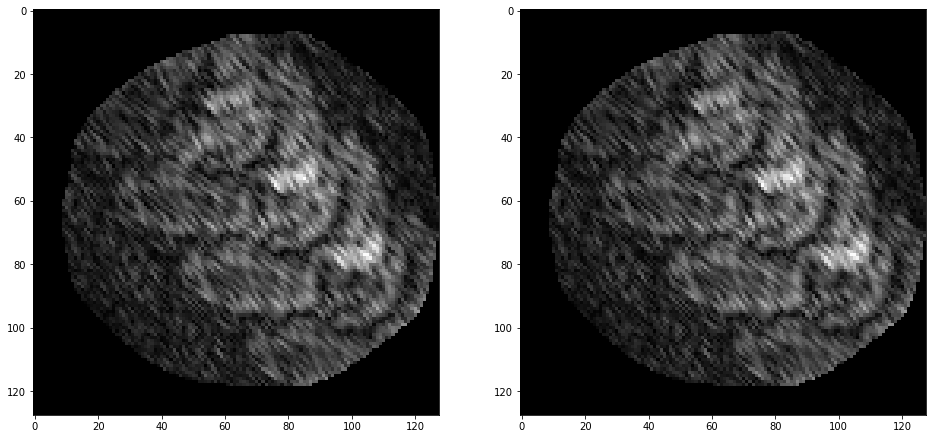

In [ ]:
plt.figure(figsize=(16, 16)) 
plt.subplot(1,2,1)
plt.imshow(np.abs(x0[0,:,:,2]))
plt.gray()

plt.subplot(1,2,2)
plt.imshow(np.abs(x1[0,:,:,2]))
plt.gray()